Starting hyperparameter tuning for 7 configurations...

--- Training Configuration 1/7 ---
Hyperparameters: {'HIDDEN_DIM': 16, 'DROPOUT': 0.1, 'LR': 0.01, 'WEIGHT_DECAY': 4e-05, 'Q_NEG': 2}
Config 1 - Epoch 01 | Train Loss 0.6401 | Val AUC 0.7097
Config 1 - Epoch 02 | Train Loss 0.5573 | Val AUC 0.7936
Config 1 - Epoch 03 | Train Loss 0.4803 | Val AUC 0.8298
Config 1 - Epoch 04 | Train Loss 0.4137 | Val AUC 0.8714
Config 1 - Epoch 05 | Train Loss 0.3606 | Val AUC 0.9115
Config 1 - Epoch 06 | Train Loss 0.3293 | Val AUC 0.9167
Config 1 - Epoch 07 | Train Loss 0.3016 | Val AUC 0.9229
Config 1 - Epoch 08 | Train Loss 0.2822 | Val AUC 0.9227
Config 1 - Epoch 09 | Train Loss 0.2654 | Val AUC 0.9333
Config 1 - Epoch 10 | Train Loss 0.2445 | Val AUC 0.9337
Config 1 - Epoch 11 | Train Loss 0.2322 | Val AUC 0.9380
Config 1 - Epoch 12 | Train Loss 0.2197 | Val AUC 0.9371
Config 1 - Epoch 13 | Train Loss 0.2159 | Val AUC 0.9459
Config 1 - Epoch 14 | Train Loss 0.2018 | Val AUC 0.9435
Config 1 - E

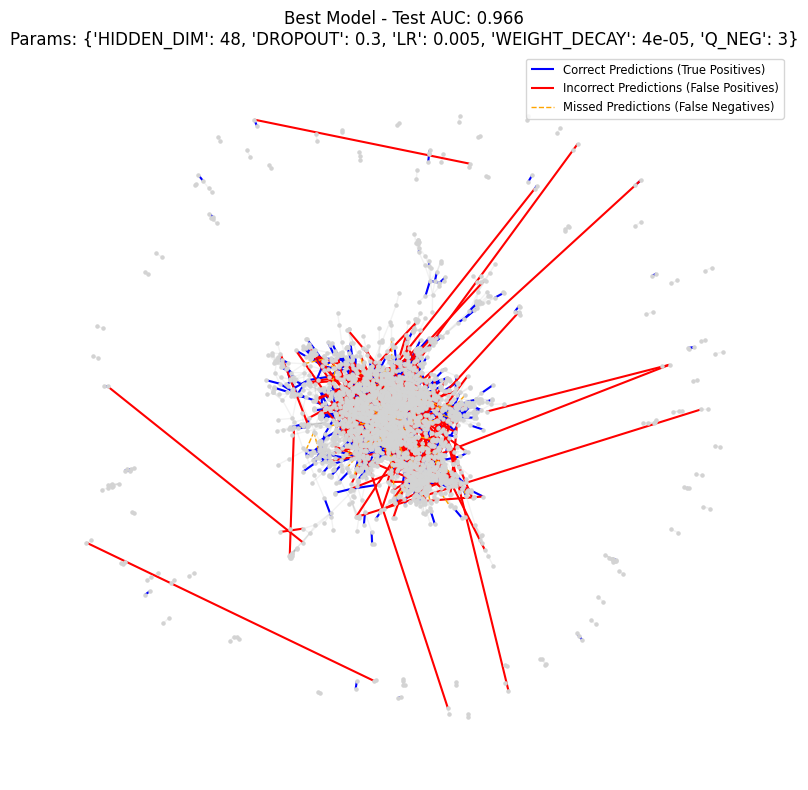

In [6]:
# 2021313549 정성수
# HW2: Citation Prediction with GCNs on Cora
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. HYPERPARAMETERS & SEED
# -----------------------------
SEED         = 42
HIDDEN_DIM   = 16
DROPOUT      = 0.1
LR           = 0.01
WEIGHT_DECAY = 4e-5
BATCH_SIZE   = 256
EPOCHS       = 30
Q_NEG        = 2
THRESHOLD    = 0.5
ES           = 5
CONTENT      = "./cora/cora.content"
CITES        = "./cora/cora.cites"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 2. LOAD & PREPROCESS DATA
# -----------------------------
def load_cora():
    # 2.1 read content
    content = pd.read_csv(CONTENT, sep='\t', header=None)        # content table (2708x1435)
    node_ids = content[0].tolist()                               # paper ids (2708)
    features = content.iloc[:,1:-1].values.astype(np.float32)    # feature table (2708x1433)
    id2idx = {nid:i for i,nid in enumerate(node_ids)}            # paper dictionary indexed by id (2708)

    # 2.2 read citations, build graph (undirected)
    G = nx.Graph()                                               # create empty graph
    G.add_nodes_from(range(len(node_ids)))                       # 2708 nodes are added

    # Add edges (undirected)
    for src, dst in pd.read_csv(CITES, sep='\t', header=None).values:
        # src - dst (undirected)
        if src in id2idx and dst in id2idx:
            u,v = id2idx[src], id2idx[dst]
            G.add_edge(u, v)

    # 2.3 build normalized adjacency
    # Adjacency matrix
    adj = nx.adjacency_matrix(G)                                 # build sparse matrix (2708x2708)
    adj = adj + np.eye(adj.shape[0])                             # add self-loops (add I)

    # Normalize adjacency
    rowsum = np.array(adj.sum(1)).flatten()                      # sum rowwise (2708)
    d_inv_sqrt = np.power(rowsum, -0.5)                          # D^(-1/2)
    D_inv_sqrt = np.diag(d_inv_sqrt)                             # make Diagonal matrix
    adj_norm = D_inv_sqrt @ adj @ D_inv_sqrt                     # normalize adj by D^(-1/2)*Adj*D^(-1/2) <- we can say kind of normalized (as we learned)
    adj_norm = torch.from_numpy(adj_norm).float()                # np -> torch

    X = torch.from_numpy(features)                               # feature matrix to torch
    edges = np.array(G.edges())                                  # edges in np array

    return X, adj_norm, edges

# -----------------------------
# 3. SPLIT & NEGATIVE SAMPLING
# -----------------------------
def split_edges(edges):
    # get undirected unique edges
    und = list({tuple(sorted(e)) for e in edges})                # no dup, (small id, big id) tuple form edges' list
    train, tmp = train_test_split(und, test_size=0.3, random_state=SEED)    # 70% train
    val, test = train_test_split(tmp, test_size=2/3, random_state=SEED)     # of the 30%: 10% val, 20% test
    return train, val, test

def sample_negatives(existing, num_nodes, k):
    # uniformly sample k negative edges (u,v) not in existing
    neg = set()                                                  # set for no dup
    while len(neg) < k:                                          # repeat until k samples
        u = random.randrange(num_nodes)
        v = random.randrange(num_nodes)
        if u==v: continue                                        # ignore self-loop
        e = (min(u,v), max(u,v))
        if e not in existing:                                    # if e is already existing, ignore
            neg.add(e)
    return list(neg)

# -----------------------------
# 4. DATASET
# -----------------------------
class LinkDataset(Dataset):                                      # DataSet Class
    def __init__(self, pos, neg):
        # pos, neg : List[(u,v)]
        self.edges = pos + neg                                   # edges list
        self.labels= [1]*len(pos) + [0]*len(neg)                 # label 1 to pos, 0 to neg
    def __len__(self): return len(self.labels)                   # #of samples
    def __getitem__(self, idx):                                  # given index -> return sample
        u,v = self.edges[idx]
        return u, v, self.labels[idx]

# -----------------------------
# 5. GCN LAYER & MODEL
# -----------------------------
class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super().__init__()
        self.lin = nn.Linear(in_feats, out_feats, bias=False)    # no bias term
        #nn.init.xavier_uniform_(self.lin.weight)                # Xavier(a.k.a Glorot) uniform initialize
        nn.init.kaiming_uniform_(self.lin.weight, nonlinearity='relu')    # He(Kaiming) uniform initialize
    def forward(self, X, A_norm):
        H = A_norm @ X
        return nn.functional.relu(self.lin(H))

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_feats, hid_feats, dropout):
        super().__init__()
        self.gc1 = GraphConv(in_feats, hid_feats)                # input -> hidden
        self.gc2 = GraphConv(hid_feats, hid_feats)               # hidden -> hidden
        self.dropout = dropout
        # decoder: 2*hid → hid → 1
        self.decoder = nn.Sequential(
            nn.Linear(2*hid_feats, hid_feats),                   # 2*hidden(concatenated) -> hidden
            nn.ReLU(),                                           # ReLU
            nn.Dropout(dropout),                                 # dropout rate 0.1
            nn.Linear(hid_feats, 1)                              # hidden -> predict score (scalar)
        )
    def forward(self, X, A_norm, pairs):
        # two-layer GCN
        h = self.gc1(X, A_norm)
        h = nn.functional.dropout(h, p=self.dropout, training=self.training)
        h = self.gc2(h, A_norm)
        # decode edges
        u = h[pairs[:,0]]                                        # u node embedding
        v = h[pairs[:,1]]                                        # v node embedding

        e = torch.cat([u,v], dim=1)
        return self.decoder(e).squeeze()                         # using self.decoder <- linear layer

        # dot product                                              without linear layer
        #logits = torch.sum(u * v, dim=1)
        #return logits

# -----------------------------
# 6. TRAIN & EVAL
# -----------------------------
def evaluate_auc(model, X, A_norm, pos, neg, device):
    model.eval()
    with torch.no_grad():                                        # while evaluating, don't calculate gradient
        # Move X and A_norm to the device
        X = X.to(device)
        A_norm = A_norm.to(device)

        P = torch.tensor(pos+neg, device=device, dtype=torch.long)
        logits = model(X, A_norm, P).cpu().numpy()               # model predict(logit)
        labels= np.array([1]*len(pos)+[0]*len(neg))              # real labels
        return roc_auc_score(labels, logits)                     # ROC AUC score

def train():
    # Define a list of hyperparameter combinations to try
    hyperparameter_configs = [
        {'HIDDEN_DIM': HIDDEN_DIM, 'DROPOUT': DROPOUT, 'LR': LR, 'WEIGHT_DECAY': WEIGHT_DECAY, 'Q_NEG': Q_NEG},
        {'HIDDEN_DIM': 32, 'DROPOUT': 0.1, 'LR': 0.01, 'WEIGHT_DECAY': 4e-5, 'Q_NEG': 2},
        {'HIDDEN_DIM': 48, 'DROPOUT': 0.1, 'LR': 0.01, 'WEIGHT_DECAY': 4e-5, 'Q_NEG': 2},
        {'HIDDEN_DIM': 32, 'DROPOUT': 0.2, 'LR': 0.01, 'WEIGHT_DECAY': 5e-4, 'Q_NEG': 1},
        {'HIDDEN_DIM': 48, 'DROPOUT': 0.3, 'LR': 0.005, 'WEIGHT_DECAY': 4e-5, 'Q_NEG': 3},
        {'HIDDEN_DIM': 64, 'DROPOUT': 0.15, 'LR': 0.01, 'WEIGHT_DECAY': 1e-4, 'Q_NEG': 2},
        {'HIDDEN_DIM': 16, 'DROPOUT': 0.25, 'LR': 0.001, 'WEIGHT_DECAY': 5e-4, 'Q_NEG': 1},
    ]

    # load data
    X_orig, A_norm_orig, edges = load_cora()
    N_nodes, F_features = X_orig.size()
    # split
    pos_train, pos_val, pos_test = split_edges(edges)
    existing = set(tuple(sorted(e)) for e in edges)

    best_overall_val_auc = 0.0
    best_hyperparams = None
    best_model_state = None
    final_test_auc_for_best_model = 0.0

    print(f"Starting hyperparameter tuning for {len(hyperparameter_configs)} configurations...")

    for i, params in enumerate(hyperparameter_configs):
        print(f"\n--- Training Configuration {i+1}/{len(hyperparameter_configs)} ---")
        print(f"Hyperparameters: {params}")

        current_hidden_dim = params['HIDDEN_DIM']
        current_dropout = params['DROPOUT']
        current_lr = params['LR']
        current_weight_decay = params['WEIGHT_DECAY']
        current_q_neg = params['Q_NEG']

        # Resample negatives for current Q_NEG
        neg_train = sample_negatives(existing, N_nodes, len(pos_train) * current_q_neg)
        neg_val = sample_negatives(existing, N_nodes, len(pos_val) * current_q_neg)

        # dataloader
        train_ds = LinkDataset(pos_train, neg_train)
        # BATCH_SIZE is kept global for now, could also be part of params
        train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)

        # model & optimizer
        model = GCNLinkPredictor(F_features, current_hidden_dim, current_dropout).to(device)
        optim = torch.optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_weight_decay)

        # training loop for current configuration
        current_best_val_auc, patience = 0.0, 0
        current_best_model_state_for_config = None

        # Move data to device (ensure fresh copies for each model if manipulated in-place, though not the case here)
        X = X_orig.clone().to(device)
        A_norm = A_norm_orig.clone().to(device)

        for epoch in range(1, EPOCHS+1):
            model.train()
            losses = []
            for us,vs,ys in train_loader:
                us = us.to(device); vs = vs.to(device)
                ys = ys.float().to(device)
                pairs = torch.stack([us,vs], dim=1)
                optim.zero_grad()
                logits = model(X, A_norm, pairs)
                loss = nn.functional.binary_cross_entropy_with_logits(logits, ys)
                loss.backward()
                optim.step()
                losses.append(loss.item())

            # validate
            val_auc = evaluate_auc(model, X, A_norm, pos_val, neg_val, device) # neg_val is sampled per config
            print(f"Config {i+1} - Epoch {epoch:02d} | Train Loss {np.mean(losses):.4f} | Val AUC {val_auc:.4f}")

            # early stopping
            if val_auc > current_best_val_auc:
                current_best_val_auc = val_auc
                patience = 0
                current_best_model_state_for_config = {k:v.cpu() for k,v in model.state_dict().items()}
            else:
                patience += 1
                if patience >= ES:
                    print(f"Config {i+1} - Early stopping at epoch {epoch}.")
                    break

        print(f"Config {i+1} - Best Val AUC: {current_best_val_auc:.4f}")

        if current_best_val_auc > best_overall_val_auc:
            best_overall_val_auc = current_best_val_auc
            best_hyperparams = params
            best_model_state = current_best_model_state_for_config
            # Evaluate this model on test set to store its test AUC
            if best_model_state: # if a model was actually trained (not stopped at epoch 0)
                temp_model_for_test_eval = GCNLinkPredictor(F_features, best_hyperparams['HIDDEN_DIM'], best_hyperparams['DROPOUT']).to(device)
                temp_model_for_test_eval.load_state_dict({k:v.to(device) for k,v in best_model_state.items()})
                # Use neg_test corresponding to the Q_NEG of the best model
                neg_test = sample_negatives(existing, N_nodes, len(pos_test) * best_hyperparams['Q_NEG'])
                final_test_auc = evaluate_auc(temp_model_for_test_eval, X, A_norm, pos_test, neg_test, device)
                print(f"Config {i+1} became new best model! Test AUC: {final_test_auc:.4f}")


    print(f"\n--- Hyperparameter Tuning Complete ---")
    print(f"Best Hyperparameters: {best_hyperparams}")
    print(f"Best Validation AUC: {best_overall_val_auc:.4f}")
    print(f"Corresponding Test AUC for the best model: {final_test_auc:.4f}")

    # load best model for final evaluation and visualization
    if best_model_state and best_hyperparams:
        model = GCNLinkPredictor(F_features, best_hyperparams['HIDDEN_DIM'], best_hyperparams['DROPOUT']).to(device)
        model.load_state_dict({k:v.to(device) for k,v in best_model_state.items()})

        # Ensure X and A_norm are on the correct device for visualization
        X = X_orig.clone().to(device)
        A_norm = A_norm_orig.clone().to(device)

        # Re-sample neg_test based on the Q_NEG of the best model for final visualization consistency
        final_neg_test_for_viz = sample_negatives(existing, N_nodes, len(pos_test) * best_hyperparams['Q_NEG'])

        # visualization for the best model
        G = nx.Graph()
        G.add_nodes_from(range(N_nodes))
        G.add_edges_from({tuple(sorted(e)) for e in edges})                     # original edges

        all_test_edges_for_viz = pos_test + final_neg_test_for_viz              # Use consistent negative samples

        model.eval()                                                            # Ensure model is in eval mode for predictions
        with torch.no_grad():
            P_tensor = torch.tensor(all_test_edges_for_viz, device=device, dtype=torch.long)
            scores = torch.sigmoid(model(X, A_norm, P_tensor)).cpu().numpy()

        edge_scores = {tuple(all_test_edges_for_viz[i]): float(scores[i]) for i in range(len(all_test_edges_for_viz))}

        plt.figure(figsize=(8,8))
        #pos = nx.kamada_kawai_layout(G)
        pos = nx.spring_layout(G, seed=SEED)

        true_positive_edges_in_test = set(tuple(sorted(e)) for e in pos_test)   # True positive edges from the test set

        pred_pos_edges = [e for e,s in edge_scores.items() if s >= THRESHOLD]
        correct_preds = [e for e in pred_pos_edges if tuple(sorted(e)) in true_positive_edges_in_test]
        wrong_preds = [e for e in pred_pos_edges if tuple(sorted(e)) not in true_positive_edges_in_test]

        # Edges from the original graph (light grey)
        nx.draw_networkx_nodes(G, pos, node_size=5, node_color='lightgray')     # Smaller nodes
        nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), alpha=0.1, edge_color='grey')  # All original edges faintly

        # True positives (correctly predicted as positive) - Blue
        nx.draw_networkx_edges(G, pos, edgelist=correct_preds, edge_color='blue', width=1.5, label='Correct Predictions (True Positives)')

        # False positives (incorrectly predicted as positive) - Red
        nx.draw_networkx_edges(G, pos, edgelist=wrong_preds, edge_color='red', width=1.5, label='Incorrect Predictions (False Positives)')

        false_neg_preds = [e for e in pos_test if tuple(sorted(e)) not in set(tuple(sorted(pe)) for pe in pred_pos_edges)]
        nx.draw_networkx_edges(G, pos, edgelist=false_neg_preds, edge_color='orange', width=1.0, style='dashed', label='Missed Predictions (False Negatives)')


        plt.title(f"Best Model - Test AUC: {final_test_auc:.3f}\nParams: {best_hyperparams}")
        plt.legend(loc='upper right', fontsize='small')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    train()